<font size="+3">Deep Convolutional Generative Adversarial Network (DCGAN)</font>

Ken Perry attributions:
- adapted from [Jansen DCGAN](https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/21_gans_for_synthetic_time_series/01_deep_convolutional_generative_adversarial_network.ipynb)
    - which was in turn adapted from [Chollet: DCGAN to generate face images](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/generative/dcgan.ipynb)
    - Jansen moved a lot of code from in-line to subroutines (e.g., `discriminator_loss`, `generator_loss`)
    - changed dataset to `fashion_mnist`
- I prefer Jansen's cleaner code, but changed dataset to `Celeba`, as per Chollet
---------

To illustrate the implementation of a GAN using Python, we use the [Deep Convolutional GAN](https://arxiv.org/abs/1511.06434) (DCGAN) example discussed in the Section 'Evolution of GAN Architectures' to synthesize images from the fashion MNIST dataset. 

Adapted from the [TensorFlow tutorial](https://www.tensorflow.org/tutorials/generative/dcgan) on generative modeling with the DCGAN architecture.

# Imports & Settings

In [84]:
import warnings
warnings.filterwarnings('ignore')

In [85]:
from pathlib import Path
import imageio
import matplotlib.pyplot as plt
from tqdm import tqdm
from time import time

import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import (Dense, Reshape, Flatten, Dropout,
                                     BatchNormalization, LeakyReLU,
                                     Conv2D, Conv2DTranspose)
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

from IPython import display

In [86]:
import os
import gdown
from zipfile import ZipFile

from tensorflow import keras

In [87]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [88]:
dcgan_path = Path('dcgan')
img_path = dcgan_path / 'synthetic_images'
if not img_path.exists():
    img_path.mkdir(parents=True)

# Sample Image Saver

In [89]:
scale_img = 255

In [90]:
def generate_and_save_images(model, epoch, test_input):
    # Training set to false so that every layer runs in inference mode
    predictions = model(test_input, training=False)

    fig = plt.figure(figsize=(5, 5.2))

    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i + 1)
        generated_img = predictions[i] * scale_img
        img = keras.preprocessing.image.array_to_img(generated_img)
        plt.imshow(img)
        # plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
        # plt.imshow( predictions[i, :, :, :].numpy() * scale_img )
        plt.axis('off')

    fig.suptitle(f'Epoch {epoch:03d}', fontsize=14)
    fig.tight_layout()
    fig.subplots_adjust(top=.93)
    fig.savefig(img_path / f'epoch_{epoch:03d}.png', dpi=300)
    plt.show()

# Load and Prepare Data

## Get training images

In [91]:


data_dir = "celeba_gan"
if not os.path.isdir(data_dir):
  os.makedirs(data_dir)

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"

if not os.path.exists(output):
  gdown.download(url, output, quiet=True)

with ZipFile(f"{data_dir}/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

## Extract image dimensions

In [92]:

h = w = 64
BATCH_SIZE = 32
noise_dim = 100

dataset = keras.preprocessing.image_dataset_from_directory(
    data_dir, label_mode=None, image_size=(w, h), batch_size=BATCH_SIZE
)
dataset = dataset.map(lambda x: x / (scale_img * 1.0))


Found 202599 files belonging to 1 classes.


(0.0, 1.0, 0.0, 1.0)

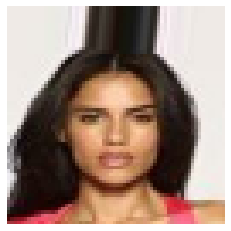

In [93]:
for x in dataset:
    plt.axis("off")
    plt.imshow((x.numpy() * scale_img).astype("int32")[0])
    break

In [94]:
x.shape

TensorShape([32, 64, 64, 3])

## Reshape to 4D input format

## Normalize pixel values

## Create `tf.data.Dataset`

# Create DCGAN Architecture

## Build Generator

In [95]:
def build_generator():
    return Sequential([Dense(8 * 8 * 256, 
                             use_bias=False,
                             input_shape=(noise_dim,), 
                             name='IN'),
                       BatchNormalization(name='BN1'),
                       LeakyReLU(name='RELU1'),
                       Reshape((8, 8, 256), name='SHAPE1'),
                       Conv2DTranspose(128, (5, 5), 
                                       strides=(1, 1),
                                       padding='same', 
                                       use_bias=False,
                                       name='CONV1'),
                       BatchNormalization(name='BN2'),
                       LeakyReLU(name='RELU2'),
                       Conv2DTranspose(64, (5, 5), 
                                       strides=(2, 2),
                                       padding='same', use_bias=False,
                                       name='CONV2'),
                       BatchNormalization(name='BN3'),
                       LeakyReLU(name='RELU3'),
                       Conv2DTranspose(32, (5, 5), 
                                       strides=(2, 2),
                                       padding='same', 
                                       use_bias=False,
                                       activation='tanh', 
                                       name='CONV3'),
                       BatchNormalization(name='BN4'),
                       LeakyReLU(name='RELU4'),
                       Conv2DTranspose(3, (5, 5), 
                                       strides=(2, 2),
                                       padding='same', use_bias=False,
                                       name='CONV4')
                        ],
                      name='Generator')

In [96]:
generator = build_generator()

In [97]:
generator.summary()

Model: "Generator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 IN (Dense)                  (None, 16384)             1638400   
                                                                 
 BN1 (BatchNormalization)    (None, 16384)             65536     
                                                                 
 RELU1 (LeakyReLU)           (None, 16384)             0         
                                                                 
 SHAPE1 (Reshape)            (None, 8, 8, 256)         0         
                                                                 
 CONV1 (Conv2DTranspose)     (None, 8, 8, 128)         819200    
                                                                 
 BN2 (BatchNormalization)    (None, 8, 8, 128)         512       
                                                                 
 RELU2 (LeakyReLU)           (None, 8, 8, 128)         0 

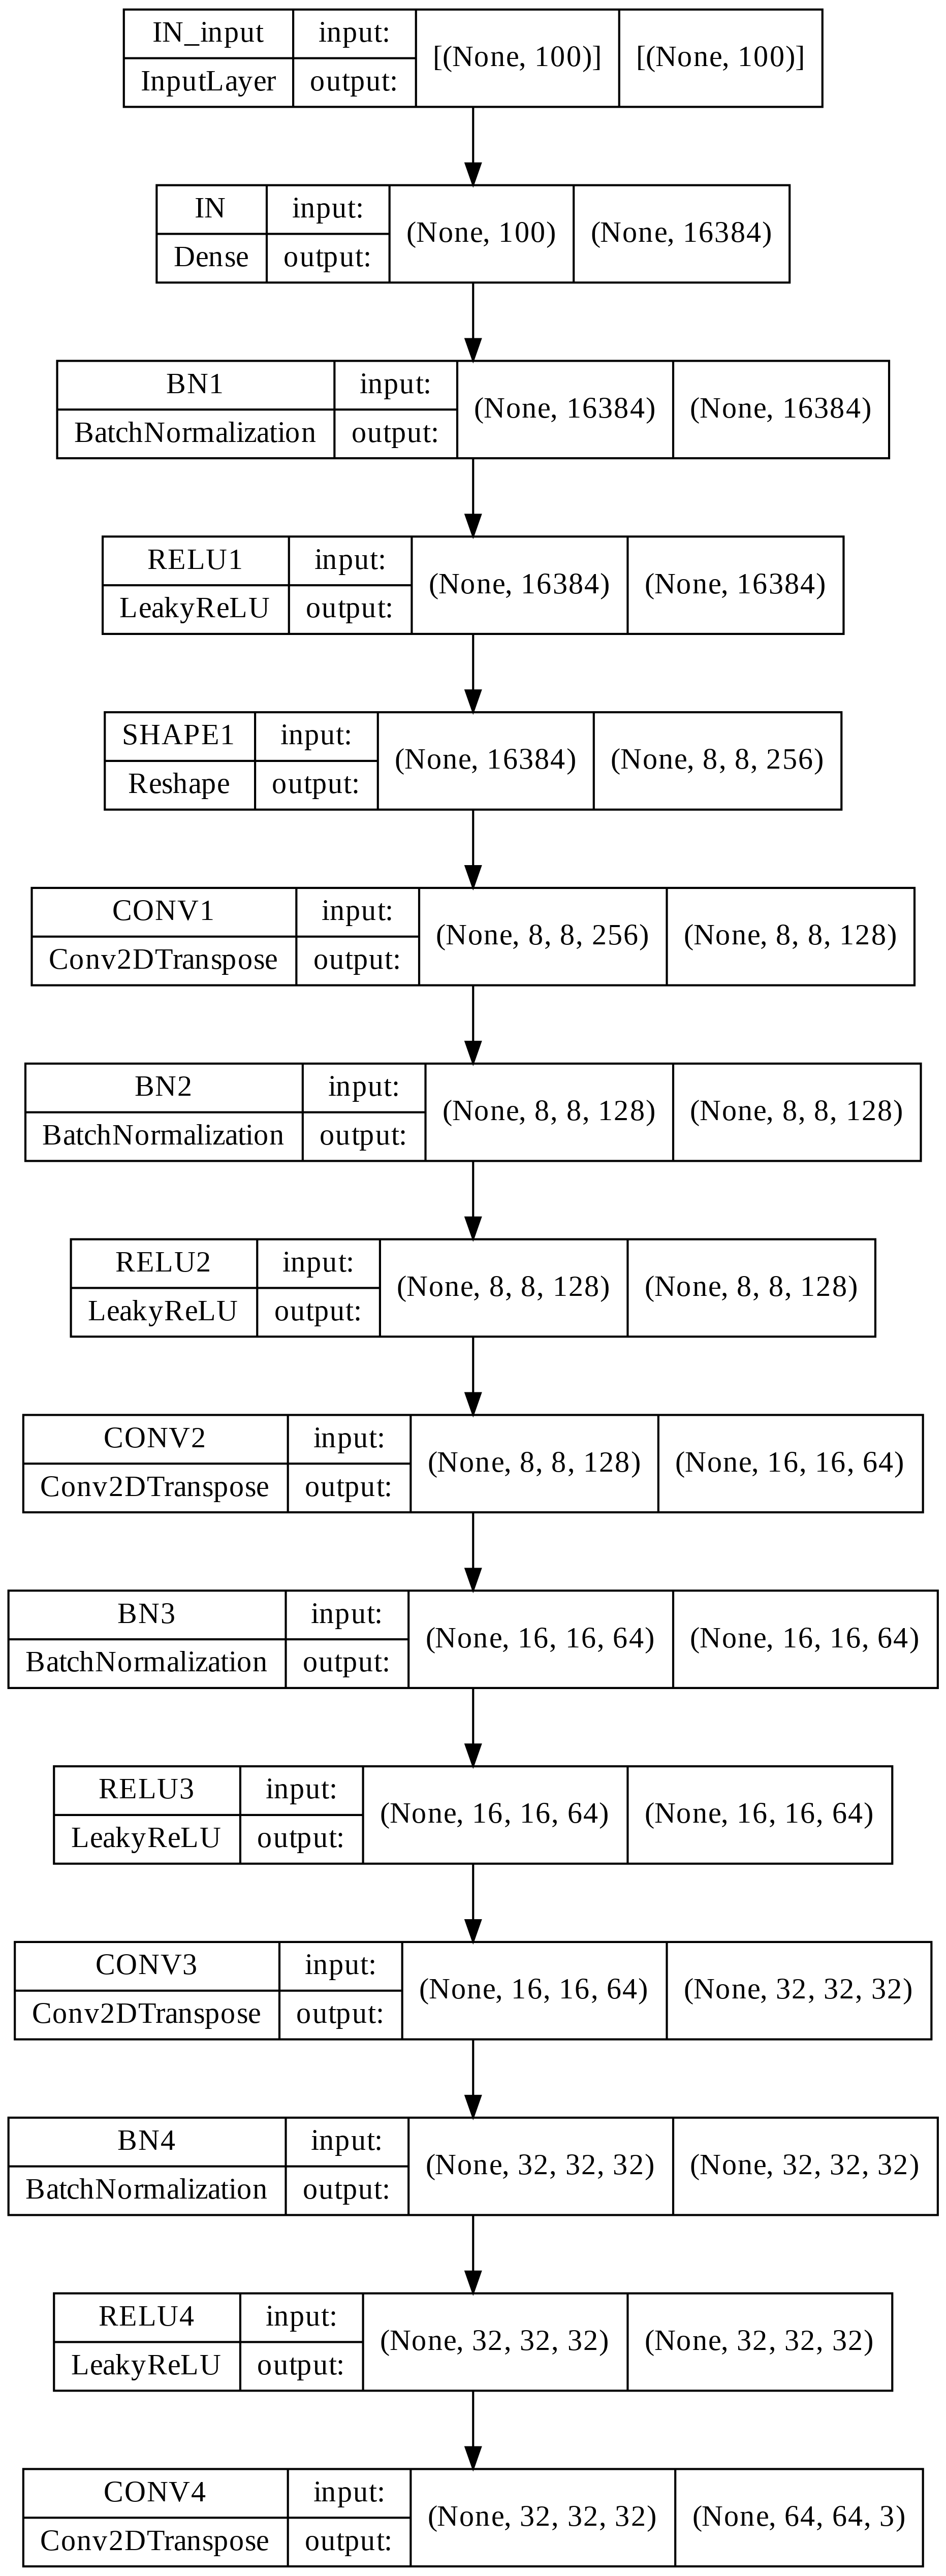

In [98]:
plot_model(generator,
           show_shapes=True,
           dpi=300,
           to_file=(dcgan_path / 'generator.png').as_posix())

### Visualize initial image quality

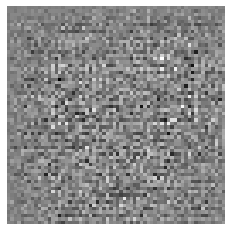

In [99]:
noise = tf.random.normal([1, 100])
generated_img = generator(noise, training=False)

plt.imshow(generated_img[0, :, :, 0], cmap='gray')
plt.axis('off');

## Build Discriminator

Both the discriminator and generator use a deep CNN architecture, wrapped in a function:

In [100]:
def build_discriminator():
    return Sequential([Conv2D(64, (5, 5), 
                              strides=(2, 2), 
                              padding='same',
                              input_shape=[w, h, 3], 
                              name='CONV1'),
                       LeakyReLU(name='RELU1'),
                       Dropout(0.3, name='DO1'),
                       Conv2D(128, (5, 5), 
                              strides=(2, 2),
                              padding='same', 
                              name='CONV2'),
                       LeakyReLU(name='RELU2'),
                       Dropout(0.3, name='DO2'),
                       Conv2D(128, (5, 5), 
                              strides=(2, 2),
                              padding='same', 
                              name='CONV3'),
                       LeakyReLU(name='RELU3'),
                       Dropout(0.3, name='DO3'),
                       Flatten(name='FLAT'),
                       Dense(1, name='OUT')],
                      name='Discriminator')

In [101]:
discriminator = build_discriminator()

In [102]:
discriminator.summary()

Model: "Discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 CONV1 (Conv2D)              (None, 32, 32, 64)        4864      
                                                                 
 RELU1 (LeakyReLU)           (None, 32, 32, 64)        0         
                                                                 
 DO1 (Dropout)               (None, 32, 32, 64)        0         
                                                                 
 CONV2 (Conv2D)              (None, 16, 16, 128)       204928    
                                                                 
 RELU2 (LeakyReLU)           (None, 16, 16, 128)       0         
                                                                 
 DO2 (Dropout)               (None, 16, 16, 128)       0         
                                                                 
 CONV3 (Conv2D)              (None, 8, 8, 128)       

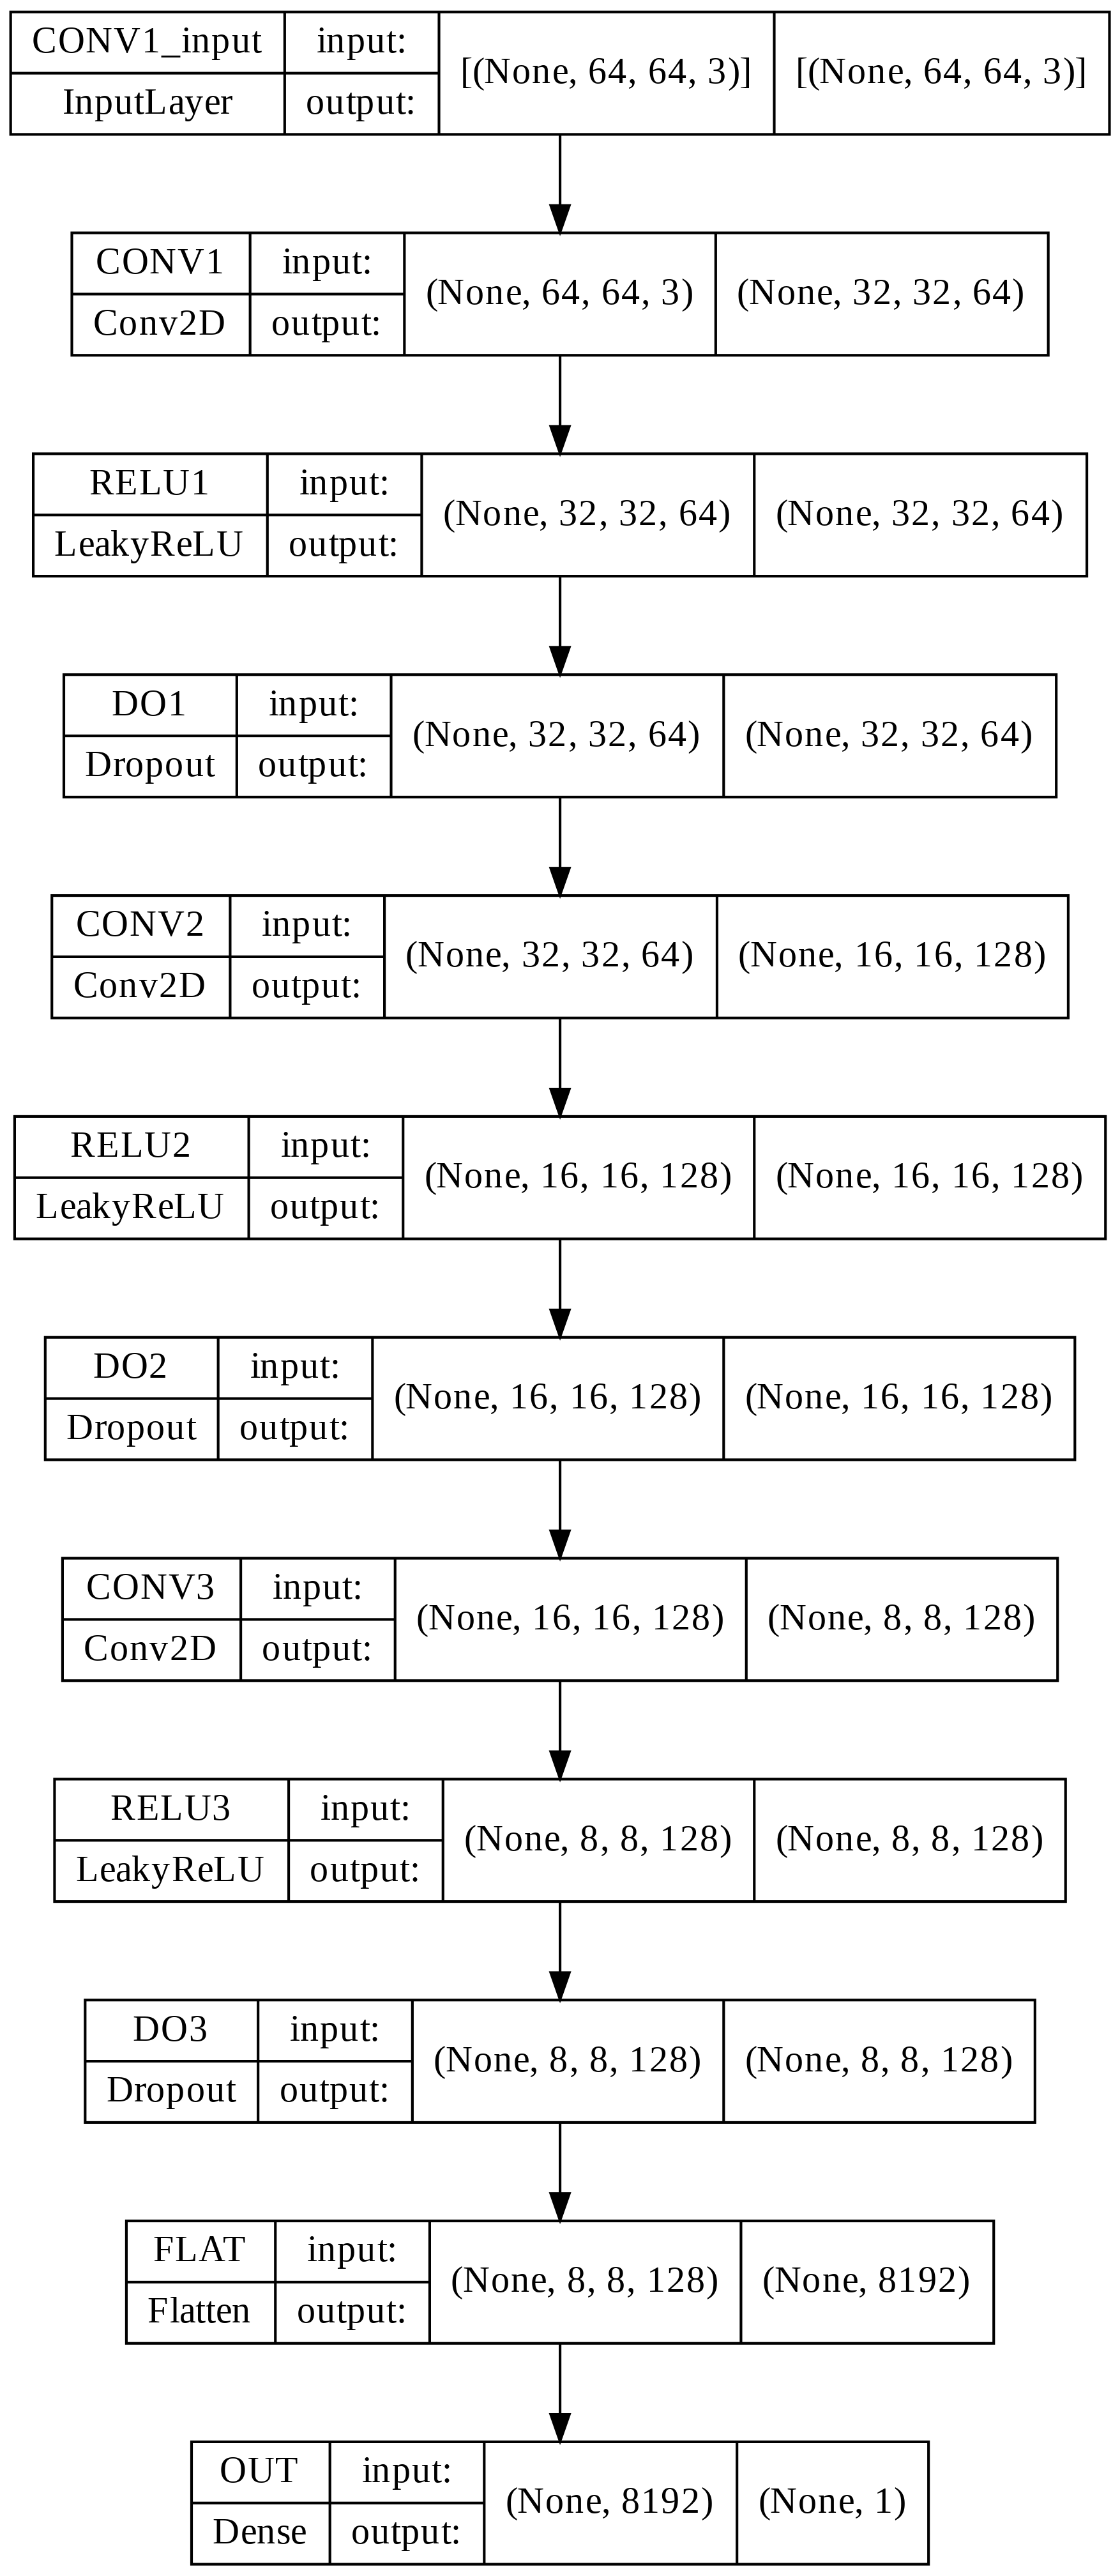

In [103]:
plot_model(discriminator,
           show_shapes=True,
           dpi=300,
           to_file=(dcgan_path / 'discriminator.png').as_posix())

### Show discriminator decision output

In [104]:
generated_img.numpy().shape

(1, 64, 64, 3)

In [105]:
discriminator(generated_img).numpy()

array([[-0.00134934]], dtype=float32)

# Adversarial Training

In [106]:
cross_entropy = BinaryCrossentropy(from_logits=True)

## Generator Loss

In [107]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

## Discriminator Loss

In [108]:
def discriminator_loss(true_output, fake_output):
    true_loss = cross_entropy(tf.ones_like(true_output), true_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return true_loss + fake_loss

## Optimizers

In [109]:
gen_optimizer = Adam(1e-4)
dis_optimizer = Adam(1e-4)

## Checkpoints

In [110]:
checkpoints_dir = dcgan_path / 'training_chpk'
checkpoint_prefix = checkpoints_dir / 'ckpt'
checkpoint = tf.train.Checkpoint(gen_optimizer=gen_optimizer,
                                 dis_optimizer=dis_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Training Parameters

In [111]:
EPOCHS = 3

d_loss_metric = keras.metrics.Mean(name="d_loss")
g_loss_metric = keras.metrics.Mean(name="g_loss")


In [112]:
# for gif generation
num_ex_to_gen = 16
seed = tf.random.normal([num_ex_to_gen, noise_dim])

The training begins with generator given a random seed as an input which is used to generate an image. The role of discriminator is to compare true image from training set with the fake image from generator. The loss is then calculated for both the models and weights are then updated through gradient descent. As we proceed further we will be having an efficient generator that is able to generate fake images close to the true images and an accurate discriminator that is able to accurately distinguish fake images from true images.

In [113]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= scale_img
        generated_images.numpy()
        for i in range(self.num_img):
            img = keras.preprocessing.image.array_to_img(generated_images[i])
            img.save("generated_img_%03d_%d.png" % (epoch, i))


## Training Step

In [114]:
@tf.function
def train_step(images):
    # generate the random input for the generator
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        
        # get the generator output
        generated_img = generator(noise, training=True)
        
        # collect discriminator decisions regarding real and fake input
        true_output = discriminator(images, training=True)
        fake_output = discriminator(generated_img, training=True)
        
        # compute the loss for each model
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(true_output, fake_output)
        
    # compute the gradients for each loss with respect to the model variables
    grad_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    grad_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    # apply the gradient to complete the backpropagation step
    gen_optimizer.apply_gradients(zip(grad_generator, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(grad_discriminator, discriminator.trainable_variables))

## Training Loop

In [115]:
def train(dataset, epochs, save_every=10):
    for epoch in tqdm(range(epochs)):
        start = time()

        for img_batch in dataset:
            train_step(img_batch)

        # produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator, epoch + 1, seed)

        # Save the model every 10 EPOCHS
        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        # Generator after final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator, epochs, seed)

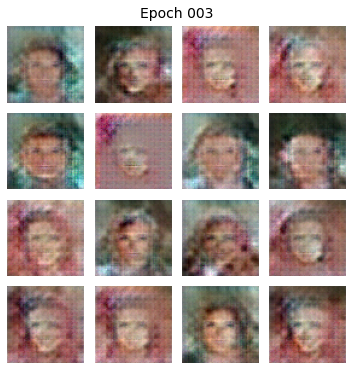

In [116]:
train(dataset, EPOCHS)

## Restore last checkpoint

In [117]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoints_dir));

# Generate animated GIF

In [118]:
out_file = dcgan_path / 'celeba.gif'

In [119]:
with imageio.get_writer(out_file, mode='I') as writer:
    filenames = sorted(list(img_path.glob('*.png')))
    
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2 * (i ** 0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

Display GIF in Colab
https://github.com/ipython/ipython/issues/10045

In [120]:
out_file

PosixPath('dcgan/celeba.gif')

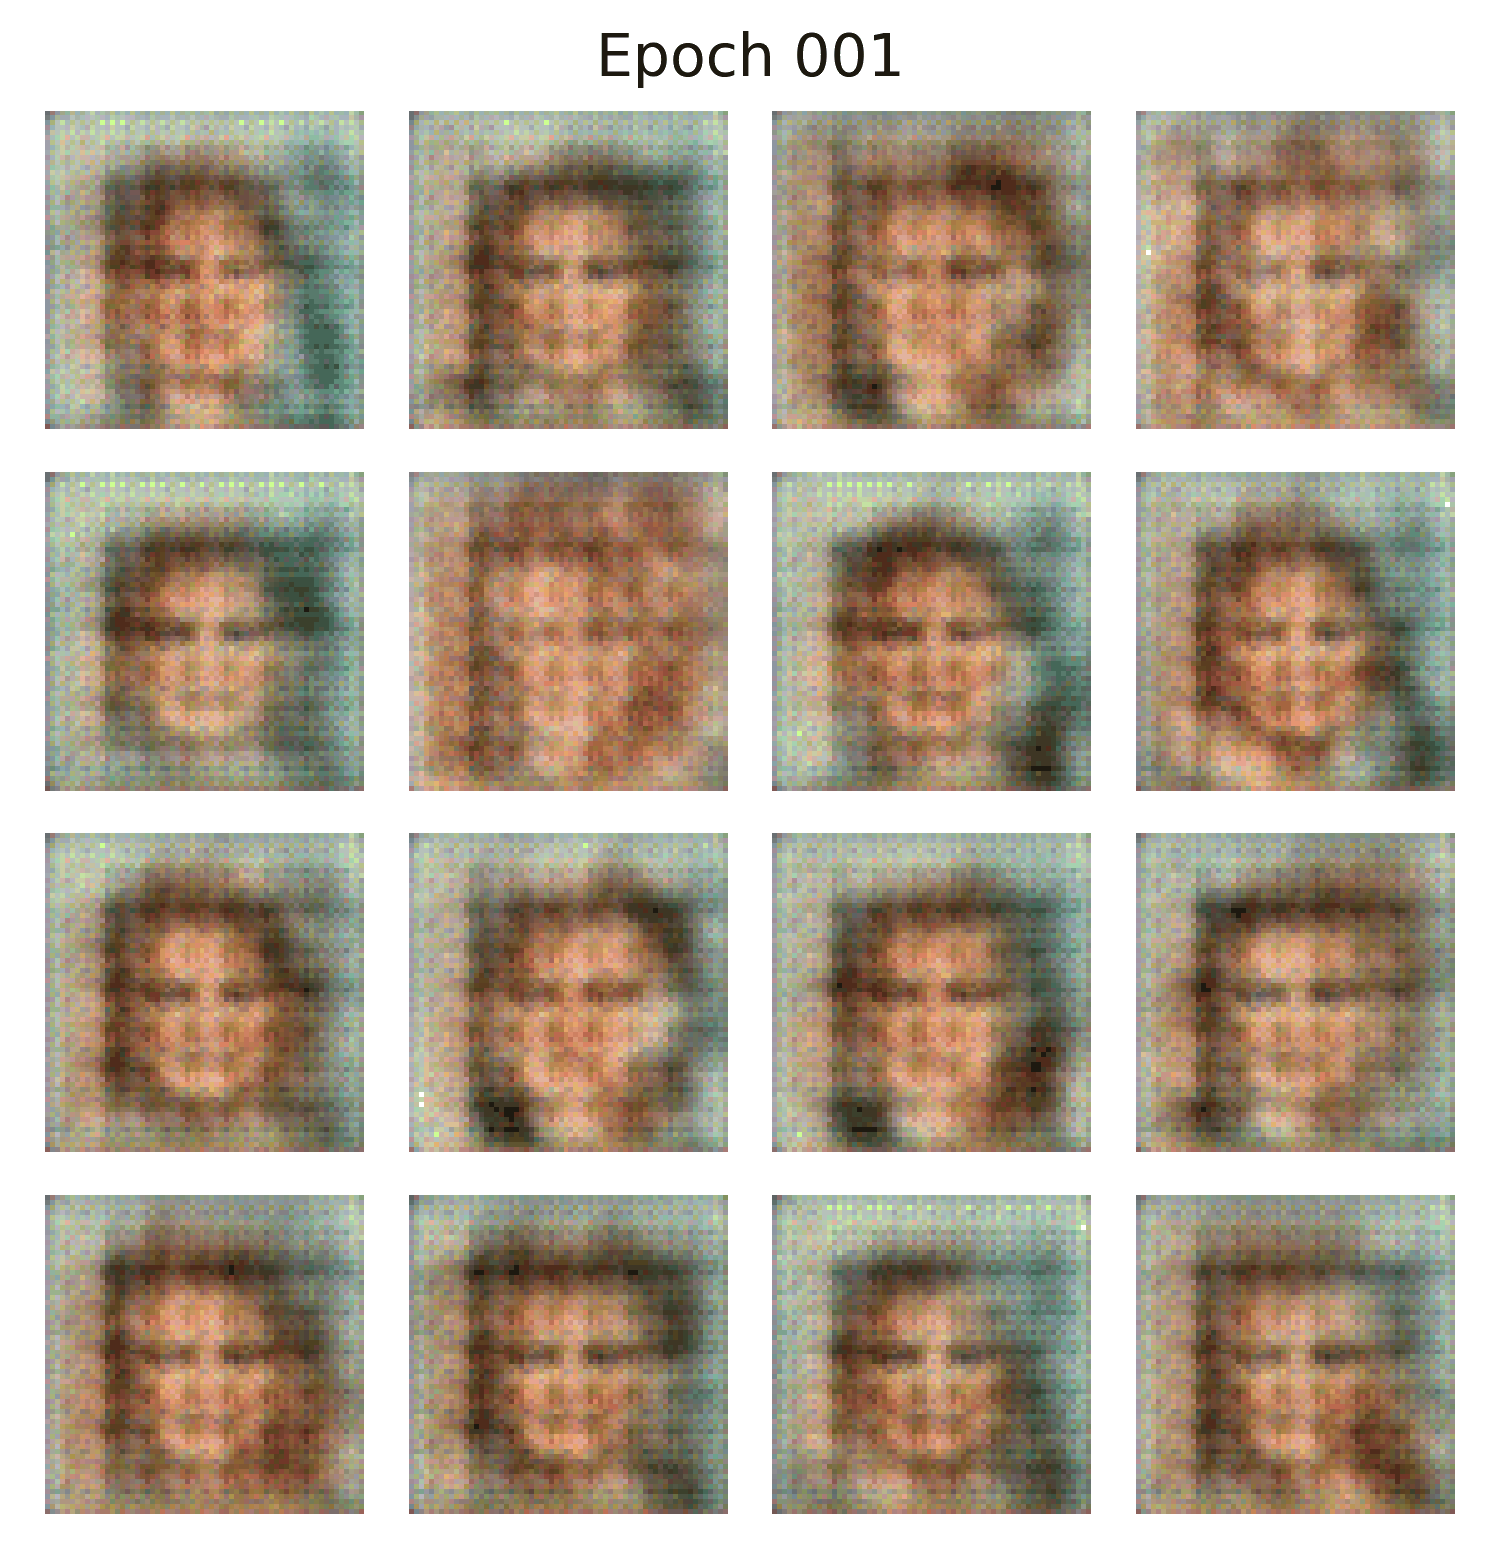

In [121]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
from IPython import display

with open(out_file,'rb') as f:
    display.Image(data=f.read(), format='png')